In [ ]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.ticker as mticker
from torchdiffeq import odeint

In [ ]:
data = pd.read_csv(
    'data_2.csv',
    dtype={
        'Rate': 'float64',
        'Currency': 'string',
        'Maturity': 'string',
        'Year': 'int64'
    },
    parse_dates=['Date'] 
)

swap_rates = data.iloc[:, -8:]  
currencies = data["Currency"] 
dates = data["Date"]

# Initialize empty lists for train and validation sets
train_data, val_data = [], []
train_dates, val_dates = [], []
train_currencies, val_currencies = [], []

# Perform train-validation split at the currency level
for currency in currencies.unique():
    currency_data = swap_rates[currencies == currency]  
    currency_dates = dates[currencies == currency] 
    currency_labels = currencies[currencies == currency]  

    train, val, train_date, val_date, train_curr, val_curr = train_test_split(
        currency_data, currency_dates, currency_labels, test_size=0.1, random_state=42
    )

    train_data.append(train)
    val_data.append(val)
    train_dates.append(train_date)
    val_dates.append(val_date)
    train_currencies.append(train_curr)
    val_currencies.append(val_curr)

train_df = pd.concat(train_data)
val_df = pd.concat(val_data)
train_dates_df = pd.concat(train_dates)
val_dates_df = pd.concat(val_dates)
train_currencies_df = pd.concat(train_currencies)
val_currencies_df = pd.concat(val_currencies)

train_tensor = torch.tensor(train_df.values, dtype=torch.float32)
val_tensor = torch.tensor(val_df.values, dtype=torch.float32)

train_dates_np = train_dates_df.to_numpy()
val_dates_np = val_dates_df.to_numpy()
train_currencies_np = train_currencies_df.to_numpy()
val_currencies_np = val_currencies_df.to_numpy()

train_indices = np.random.permutation(len(train_tensor))
train_tensor = train_tensor[train_indices]
train_dates_np = train_dates_np[train_indices]
train_currencies_np = train_currencies_np[train_indices]

val_indices = np.random.permutation(len(val_tensor))
val_tensor = val_tensor[val_indices]
val_dates_np = val_dates_np[val_indices]
val_currencies_np = val_currencies_np[val_indices]

print("Train Tensor Shape:", train_tensor.shape)
print("Validation Tensor Shape:", val_tensor.shape)

train_data_with_dates_currencies = (train_tensor, train_dates_np, train_currencies_np)
val_data_with_dates_currencies = (val_tensor, val_dates_np, val_currencies_np)

Train Tensor Shape: torch.Size([1226, 8])
Validation Tensor Shape: torch.Size([140, 8])


In [ ]:
class CenteredSoftmax(nn.Module):
    def forward(self, x):
        return 1 / (1 + torch.exp(-x)) - 0.5

class FinanceInformedAutoencoder(nn.Module):
    def __init__(self, latent_dim=2, hidden_dim=10):
        super(FinanceInformedAutoencoder, self).__init__()
        
        self.encoder = nn.Linear(8, latent_dim, bias=False) 

        self.K_output = nn.Linear(latent_dim, latent_dim, bias=True)

        self.H_hidden = nn.Linear(latent_dim, latent_dim + 2, bias=False) 
        self.H_activation = CenteredSoftmax() 
        self.H_output = nn.Linear(latent_dim + 2, latent_dim + 1, bias=False)

        self.R_hidden = nn.Linear(latent_dim, latent_dim + 2, bias=False)  
        self.R_activation = CenteredSoftmax()  
        self.R_output = nn.Linear(latent_dim + 2, 1, bias=False)

        self.decoder_hidden = nn.Linear(latent_dim + 1, hidden_dim, bias=False)
        self.activation = CenteredSoftmax()  
        self.decoder_output = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, x):
        batch_size = x.shape[0]
        z = self.encoder(x)
        z_repeated = z.unsqueeze(1).repeat(1, 30, 1)
        z_repeated.requires_grad_(True)

        maturities = torch.linspace(1, 30, steps=30, dtype=torch.float32, device=x.device).unsqueeze(0).expand(batch_size, -1)
        maturities = maturities.requires_grad_(True)

        decoder_input = torch.cat([z_repeated, maturities.unsqueeze(-1)], dim=-1)
        hidden = self.activation(self.decoder_hidden(decoder_input))
        G_out = self.decoder_output(hidden).squeeze(-1)

        mu = self.K_output(z_repeated)
        H_hidden_out = self.H_activation(self.H_hidden(z_repeated))
        H_out = self.H_output(H_hidden_out)

        R_hidden_out = self.R_activation(self.R_hidden(z_repeated))
        risk_neutral_rate = self.R_output(R_hidden_out).squeeze(-1)

        sigma1 = torch.exp(H_out[:, :, 0])
        sigma2 = torch.exp(H_out[:, :, 1])
        rho1 = torch.tanh(H_out[:, :, 2])

        sigma_matrix = torch.zeros(batch_size, 30, 2, 2, device=x.device)
        sigma_matrix[:, :, 0, 0] = sigma1
        sigma_matrix[:, :, 1, 0] = rho1 * sigma2
        sigma_matrix[:, :, 1, 1] = sigma2 * torch.sqrt(1 - rho1 ** 2)

        gradients_maturities = torch.autograd.grad(
            outputs=G_out,
            inputs=maturities,
            grad_outputs=torch.ones_like(G_out),
            create_graph=True
        )[0]

        gradients_latent = torch.autograd.grad(
            outputs=G_out,
            inputs=z_repeated,
            grad_outputs=torch.ones_like(G_out),
            create_graph=True
        )[0]

        hessian_list = []
        for i in range(z.shape[1]):
            grad2 = torch.autograd.grad(
                gradients_latent[..., i], z_repeated,
                grad_outputs=torch.ones_like(gradients_latent[..., i]),
                create_graph=True, allow_unused=False
            )[0]
            hessian_list.append(grad2.unsqueeze(-1))
        hessian = torch.cat(hessian_list, dim=-1)

        sigma_H_sigma = torch.matmul(sigma_matrix.transpose(-1, -2), torch.matmul(hessian, sigma_matrix))
        trace_sigma_H_sigma = sigma_H_sigma[..., 0, 0] + sigma_H_sigma[..., 1, 1]

        alpha = (- gradients_maturities + torch.sum(gradients_latent * mu, dim=2) + 0.5 * trace_sigma_H_sigma) / (G_out)
        beta = risk_neutral_rate / G_out

        sigma_grad_product = torch.matmul(
            gradients_latent.unsqueeze(-1), gradients_latent.unsqueeze(-2))
        gamma_matrix = torch.matmul(sigma_matrix.transpose(-1, -2), torch.matmul(sigma_grad_product, sigma_matrix))
        gamma = 0.5 * (gamma_matrix[..., 0, 0] + gamma_matrix[..., 1, 1])
        
        alpha = torch.cat([alpha[:, :1], alpha], dim=1)
        beta = torch.cat([beta[:, :1], beta], dim=1)
        gamma = torch.cat([gamma[:, :1], gamma], dim=1)
        taus = torch.arange(0, 31, dtype=torch.float32, device=x.device) 

        def piecewise_interp(t, grid, values):

            idx = torch.searchsorted(grid, t, right=True) - 1
            idx = idx.clamp(0, grid.shape[-1] - 1)
            return values[:, idx]

        def ode_func(t, state):
            A, B = state[..., 0], state[..., 1]
            alpha_t = piecewise_interp(t, taus, alpha)
            beta_t = piecewise_interp(t, taus, beta)
            gamma_t = piecewise_interp(t, taus, gamma)
            dB = alpha_t * B + beta_t
            dA = gamma_t * B**2
            return torch.stack([dA, dB], dim=-1)

        A0 = torch.zeros(batch_size, device=x.device)
        B0 = torch.zeros(batch_size, device=x.device)
        initial_state = torch.stack([A0, B0], dim=-1)

        sol = odeint(ode_func, initial_state, taus, method='rk4')  
        sol = sol.permute(1, 0, 2) 
        A_vals, B_vals = sol[..., 0][:, 1:], sol[..., 1][:, 1:]  

        discount_factors = torch.exp(A_vals - B_vals * G_out)
        cumulative_sums = torch.tril(torch.ones(30, 30, device=discount_factors.device)) @ discount_factors.T
        cumulative_sums = cumulative_sums.T
        swap_rates = (1 - discount_factors) / cumulative_sums

        return G_out, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors, swap_rates

# Set fixed parameters
initial_learning_rate = 0.005  
batch_size = 32
latent_dim = 2
hidden_dim = 10
epochs = 100

# Prepare data loaders
train_loader = DataLoader(train_tensor, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_tensor, batch_size=batch_size, shuffle=False)

# Initialize model, optimizer, and loss function
model = FinanceInformedAutoencoder(latent_dim=latent_dim, hidden_dim=hidden_dim)
optimizer = optim.Adam(model.parameters(), lr=initial_learning_rate)

# Learning rate scheduler
def lr_lambda(epoch):
    return 0.9 ** (epoch // 50)  
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

criterion = nn.MSELoss()
train_losses = []
val_losses = []

best_val_loss = float('inf')
best_model_state = None

# Training loop
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    for X_batch in train_loader:
        optimizer.zero_grad()
        G_out, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors, swap_rates = model(X_batch)
        loss = criterion(swap_rates[:, [0, 1, 2, 4, 9, 14, 19, 29]], X_batch)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    
    avg_train_loss = (total_train_loss / len(train_loader)) ** 0.5  
    train_losses.append(avg_train_loss)
    
    # Validation
    model.eval()
    total_val_loss = 0
    for X_batch in val_loader:
        G_out, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors, swap_rates = model(X_batch)
        val_loss = criterion(swap_rates[:, [0, 1, 2, 4, 9, 14, 19, 29]], X_batch)
        total_val_loss += val_loss.item()
    
    avg_val_loss = (total_val_loss / len(val_loader)) ** 0.5 
    val_losses.append(avg_val_loss)
    
    # Update learning rate scheduler
    scheduler.step()

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()
    
    # Print progress every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Train RMSE: {avg_train_loss:.6f}, Val RMSE: {avg_val_loss:.6f}, LR: {scheduler.get_last_lr()[0]:.6f}")

model.load_state_dict(best_model_state) 
torch.save(best_model_state, "best_affine_model_torch_2_new_test.pt")  

Epoch 0, Train RMSE: 0.019402, Val RMSE: 0.016012, LR: 0.005000
Epoch 100, Train RMSE: 0.003819, Val RMSE: 0.003308, LR: 0.004050
Epoch 200, Train RMSE: 0.001691, Val RMSE: 0.001559, LR: 0.003280
Epoch 300, Train RMSE: 0.001480, Val RMSE: 0.001418, LR: 0.002657
Epoch 400, Train RMSE: 0.001427, Val RMSE: 0.001387, LR: 0.002152
Epoch 500, Train RMSE: 0.001401, Val RMSE: 0.001357, LR: 0.001743
Epoch 600, Train RMSE: 0.001383, Val RMSE: 0.001344, LR: 0.001412
Epoch 700, Train RMSE: 0.001368, Val RMSE: 0.001319, LR: 0.001144
Epoch 800, Train RMSE: 0.001349, Val RMSE: 0.001324, LR: 0.000927
Epoch 900, Train RMSE: 0.001344, Val RMSE: 0.001300, LR: 0.000750
Epoch 1000, Train RMSE: 0.001336, Val RMSE: 0.001293, LR: 0.000608
Epoch 1100, Train RMSE: 0.001330, Val RMSE: 0.001288, LR: 0.000492
Epoch 1200, Train RMSE: 0.001328, Val RMSE: 0.001279, LR: 0.000399
Epoch 1300, Train RMSE: 0.001323, Val RMSE: 0.001275, LR: 0.000323
Epoch 1400, Train RMSE: 0.001313, Val RMSE: 0.001274, LR: 0.000262
Epoch 1

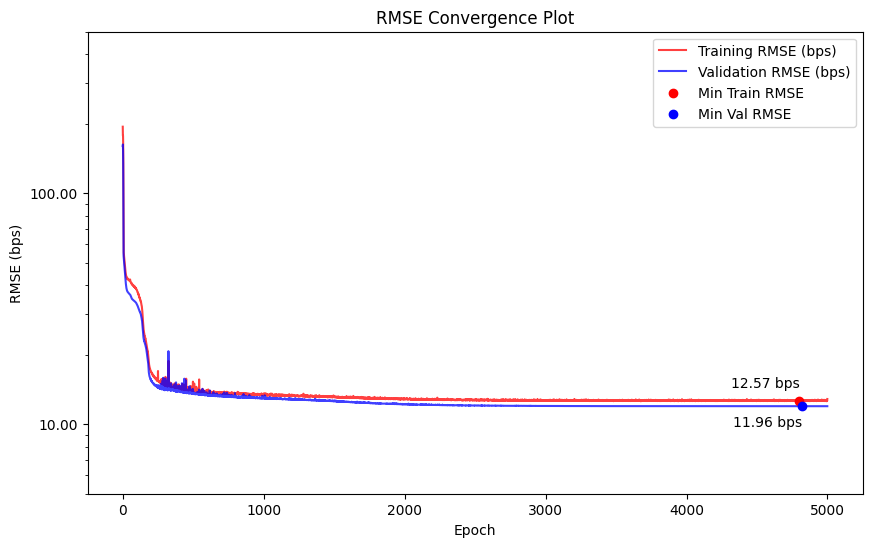

In [ ]:
train_losses_bps = [loss * 10_000 for loss in train_losses]
val_losses_bps = [loss * 10_000 for loss in val_losses]

# Find min RMSE values in basis points and corresponding epochs
min_train_rmse_bps = min(train_losses_bps)
min_train_epoch = train_losses_bps.index(min_train_rmse_bps)

min_val_rmse_bps = min(val_losses_bps)
min_val_epoch = val_losses_bps.index(min_val_rmse_bps)

# Plot RMSE convergence
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_losses_bps, label='Training RMSE (bps)', alpha=0.75, color = "red")
plt.plot(range(epochs), val_losses_bps, label='Validation RMSE (bps)', alpha=0.75, color = "blue")

# Highlight min points
plt.scatter(min_train_epoch, min_train_rmse_bps, color='red', zorder=3, label='Min Train RMSE')
plt.scatter(min_val_epoch, min_val_rmse_bps, color='blue', zorder=3, label='Min Val RMSE')

# Annotate min points with their values in basis points
plt.text(min_train_epoch, min_train_rmse_bps + 1.5, f"{min_train_rmse_bps:.2f} bps", 
         verticalalignment='bottom', horizontalalignment='right', fontsize=10, color='black')

plt.text(min_val_epoch, min_val_rmse_bps - 2.5, f"{min_val_rmse_bps:.2f} bps", 
         verticalalignment='bottom', horizontalalignment='right', fontsize=10, color='black')

plt.xlabel('Epoch')
plt.ylabel('RMSE (bps)')
plt.yscale('log') 
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter("%.2f"))
plt.title('RMSE Convergence Plot')
plt.ylim(5, 500)
plt.yticks([10, 100])
plt.legend()
plt.show()

In [ ]:
#model.load_state_dict(torch.load("best_fiae2_model.pt"))

model.eval()

data_full = pd.read_csv('data_2_full.csv', parse_dates=['Date'])

# Filter for test data from 2023 and 2024
test_df = data_full[data_full['Date'].dt.year.isin([2023, 2024])].copy()

# Define function to compute RMSE and Arbitrage Loss
def compute_metrics(model, data_tensor):
    model.eval()
    G_out, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors, swap_rates = model(data_tensor)

    mse_loss = nn.MSELoss()(swap_rates[:, [0, 1, 2, 4, 9, 14, 19, 29]], data_tensor)
    rmse = mse_loss.sqrt().item() * 10_000  

    return rmse

currency_metrics = []
for currency in currencies.unique():
    currency_train_tensor = torch.tensor(
        train_df.loc[currencies == currency].values, dtype=torch.float32
    )
    currency_val_tensor = torch.tensor(
        val_df.loc[currencies == currency].values, dtype=torch.float32
    )
    currency_test_tensor = torch.tensor(
        test_df[test_df['Currency'] == currency].iloc[:, 2:].values, dtype=torch.float32
    )

    train_rmse = compute_metrics(model, currency_train_tensor)
    val_rmse = compute_metrics(model, currency_val_tensor)
    test_rmse = compute_metrics(model, currency_test_tensor)

    currency_metrics.append({
        "Currency": currency,
        "Train RMSE (bps)": train_rmse,
        "Validation RMSE (bps)": val_rmse,
        "Test RMSE (bps)": test_rmse
    })

rmse_df = pd.DataFrame(currency_metrics)

# Add average row
average_train_rmse = rmse_df["Train RMSE (bps)"].mean()
average_val_rmse = rmse_df["Validation RMSE (bps)"].mean()

rmse_df.loc[len(rmse_df)] = [
    "Average",
    rmse_df["Train RMSE (bps)"].mean(),
    rmse_df["Validation RMSE (bps)"].mean(),
    rmse_df["Test RMSE (bps)"].mean()
]

# Print DataFrame
print(rmse_df.to_string(index=False))

Currency  Train RMSE (bps)  Validation RMSE (bps)  Test RMSE (bps)
     AUD         13.203738              10.564871        14.119826
     CAD         10.561254               8.953299        38.769869
     DKK         12.292524              10.260813        24.100768
     EUR         16.696001              18.054693        25.709325
     GBP         11.242985              11.642702              NaN
     JPY         14.234416              14.985460         6.662966
     NOK         10.693817              11.811842        32.367602
     SEK         11.154608              10.336312        27.031910
     USD         12.149690              10.887121        45.704539
 Average         12.469893              11.944124        26.808351


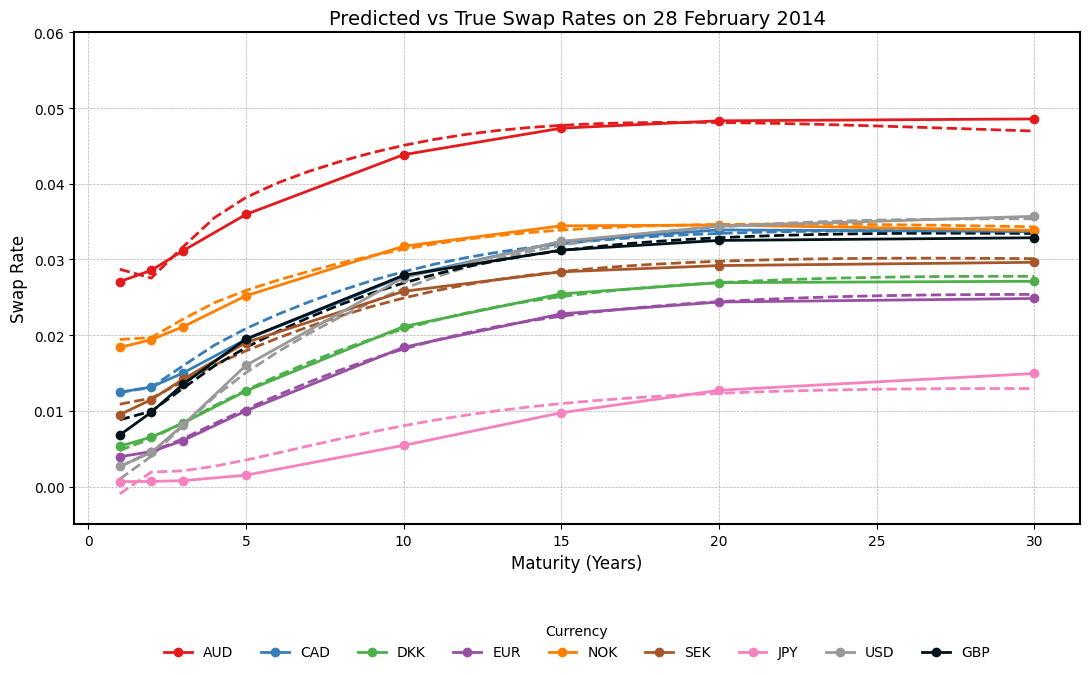

In [ ]:
train_tensor, train_dates_np, train_currencies_np = train_data_with_dates_currencies
val_tensor, val_dates_np, val_currencies_np = val_data_with_dates_currencies

# Filter for target date
target_date = np.datetime64("2014-02-28")
date_filter_train = train_dates_np == target_date
date_filter_val = val_dates_np == target_date

selected_train_data = train_tensor[date_filter_train]
selected_val_data = val_tensor[date_filter_val]

selected_train_currencies = train_currencies_np[date_filter_train]
selected_val_currencies = val_currencies_np[date_filter_val]

selected_data = torch.cat((selected_train_data, selected_val_data), dim=0)
selected_currencies = np.concatenate((selected_train_currencies, selected_val_currencies))

# Get predictions
model.eval()
G_out, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors, swap_rates_pred = model(selected_data)

# Define maturities
selected_maturities = [1, 2, 3, 5, 10, 15, 20, 30]
full_maturities = list(range(1, 31))

plot_data = []
for i, currency in enumerate(selected_currencies):
    true_row = selected_data[i].cpu().numpy()
    pred_row = swap_rates_pred[i]

    for m_idx, m in enumerate(selected_maturities):
        plot_data.append({"Maturity": m, "Rate": true_row[m_idx], "Currency": currency, "Type": "True"})
    for m in range(1, 31):
        plot_data.append({"Maturity": m, "Rate": pred_row[m-1].item(), "Currency": currency, "Type": "Predicted"})

df_plot = pd.DataFrame(plot_data)

legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

plt.figure(figsize=(11, 7))

sns.lineplot(
    data=df_plot[df_plot["Type"] == "Predicted"],
    x="Maturity", y="Rate",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette,
    linewidth=2,
    linestyle="--",
    legend=False
)

true_lines = sns.lineplot(
    data=df_plot[df_plot["Type"] == "True"],
    x="Maturity", y="Rate",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette,
    linewidth=2,
    marker='o'
)

for line in true_lines.lines:
    if line.get_marker() != 'None':
        line.set_markersize(7)
        line.set_markerfacecolor(line.get_color())
        line.set_markeredgewidth(0)

plt.xticks(ticks=range(0, 31, 5))
plt.yticks(ticks=np.arange(-0.01, 0.061, 0.01))
plt.ylim(-0.005, 0.06)

plt.title("Predicted vs True Swap Rates on 28 February 2014", fontsize=14, ha="center")
plt.xlabel("Maturity (Years)", fontsize=12)
plt.ylabel("Swap Rate", fontsize=12)

# Legend
plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.grid(True, linestyle="--", linewidth=0.5)
for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.show()

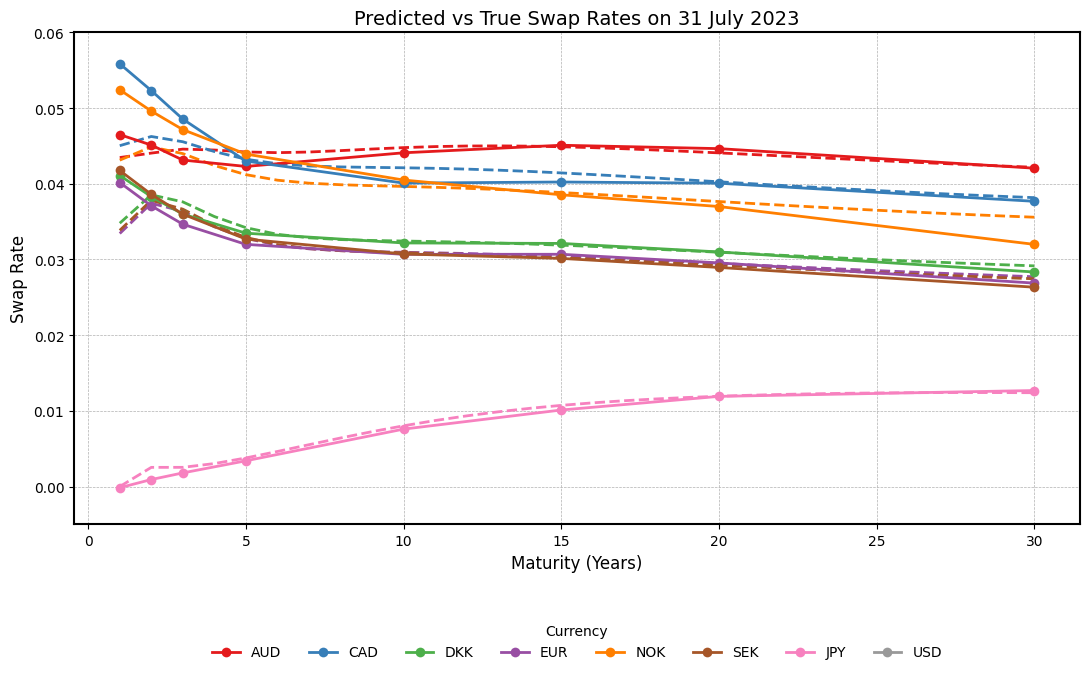

In [ ]:
plot_date = pd.to_datetime("2023-07-31")
data_full["Date"] = pd.to_datetime(data_full["Date"])
filtered_data = data_full[data_full["Date"] == plot_date].copy()

maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
filtered_data_tensor = torch.tensor(filtered_data[maturity_cols].values, dtype=torch.float32)
filtered_currencies = filtered_data["Currency"].values

model.eval()
G_out, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors, predicted_swaps = model(filtered_data_tensor)

plot_data = []
for i, currency in enumerate(filtered_currencies):
    true_row = filtered_data_tensor[i].numpy()
    pred_row = predicted_swaps[i]
    for m_idx, (maturity, true_rate) in enumerate(zip(maturity_cols, true_row)):
        plot_data.append({"Maturity": int(maturity.rstrip("Y")), "Rate": true_rate, "Currency": currency, "Type": "True"})
    for m in range(1, 31):
        plot_data.append({"Maturity": m, "Rate": pred_row[m-1].item(), "Currency": currency, "Type": "Predicted"})

df_plot = pd.DataFrame(plot_data)

legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', 'USD']
custom_palette = {
    'AUD': "#E41A1C",
    'CAD': "#377EB8",
    'DKK': "#4DAF4A",
    'EUR': "#984EA3",
    'NOK': "#FF7F00",
    'SEK': "#A65628",
    'JPY': "#F781BF",
    'USD': "#999999",  
}

plt.figure(figsize=(11, 7))

sns.lineplot(
    data=df_plot[df_plot["Type"] == "Predicted"],
    x="Maturity", y="Rate",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette,
    linewidth=2,
    linestyle='--',
    legend=False
)

lineplot = sns.lineplot(
    data=df_plot[df_plot["Type"] == "True"],
    x="Maturity", y="Rate",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette,
    linewidth=2,
    marker='o'
)

for line in lineplot.lines:
    if line.get_marker() != 'None':
        line.set_markersize(7)                    
        line.set_markerfacecolor(line.get_color())
        line.set_markeredgewidth(0)                

plt.xticks(ticks=range(0, 31, 5))
plt.yticks(ticks=np.arange(-0.01, 0.061, 0.01))
plt.ylim(-0.005, 0.06)

plt.title("Predicted vs True Swap Rates on 31 July 2023", fontsize=14, ha="center")
plt.xlabel("Maturity (Years)", fontsize=12)
plt.ylabel("Swap Rate", fontsize=12)

plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=8,
    frameon=False
)

plt.grid(True, linestyle="--", linewidth=0.5)
for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.show()

In [ ]:
maturity_labels = [1, 2, 3, 5, 10, 15, 20, 30]
selected_indices = [0, 1, 2, 4, 9, 14, 19, 29]

def compute_rmse_per_maturity(model, data_tensor):
    model.eval()
    G_out, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors, swap_rates = model(data_tensor)
    swap_rates_selected = swap_rates[:, selected_indices]

    mse_per_maturity = torch.mean((swap_rates_selected - data_tensor) ** 2, dim=0)
    rmse_per_maturity = torch.sqrt(mse_per_maturity) * 10_000 
    return rmse_per_maturity.cpu().detach().numpy()

rmse_train = compute_rmse_per_maturity(model, train_tensor)
rmse_val   = compute_rmse_per_maturity(model, val_tensor)

data_full = pd.read_csv('data_2_full.csv', parse_dates=['Date'])
test_df = data_full[data_full['Date'].dt.year.isin([2023, 2024])].copy()
test_tensor = torch.tensor(test_df.iloc[:, 2:].values, dtype=torch.float32)
rmse_test = compute_rmse_per_maturity(model, test_tensor)

rmse_by_maturity = pd.DataFrame({
    "Maturity (Years)": maturity_labels,
    "Train RMSE (bps)": rmse_train,
    "Validation RMSE (bps)": rmse_val,
    "Test RMSE (bps)": rmse_test
})

rmse_by_maturity

,Maturity (Years),Train RMSE (bps),Validation RMSE (bps),Test RMSE (bps)
0,1,19.342157,16.505991,68.002113
1,2,13.794417,14.402693,22.132553
2,3,13.724249,13.846785,20.969196
3,5,14.900196,14.802471,15.507429
4,10,9.680569,9.244139,9.936951
5,15,5.885087,6.379089,5.924552
6,20,6.485252,7.882854,4.820414
7,30,11.594807,11.209660,12.102617


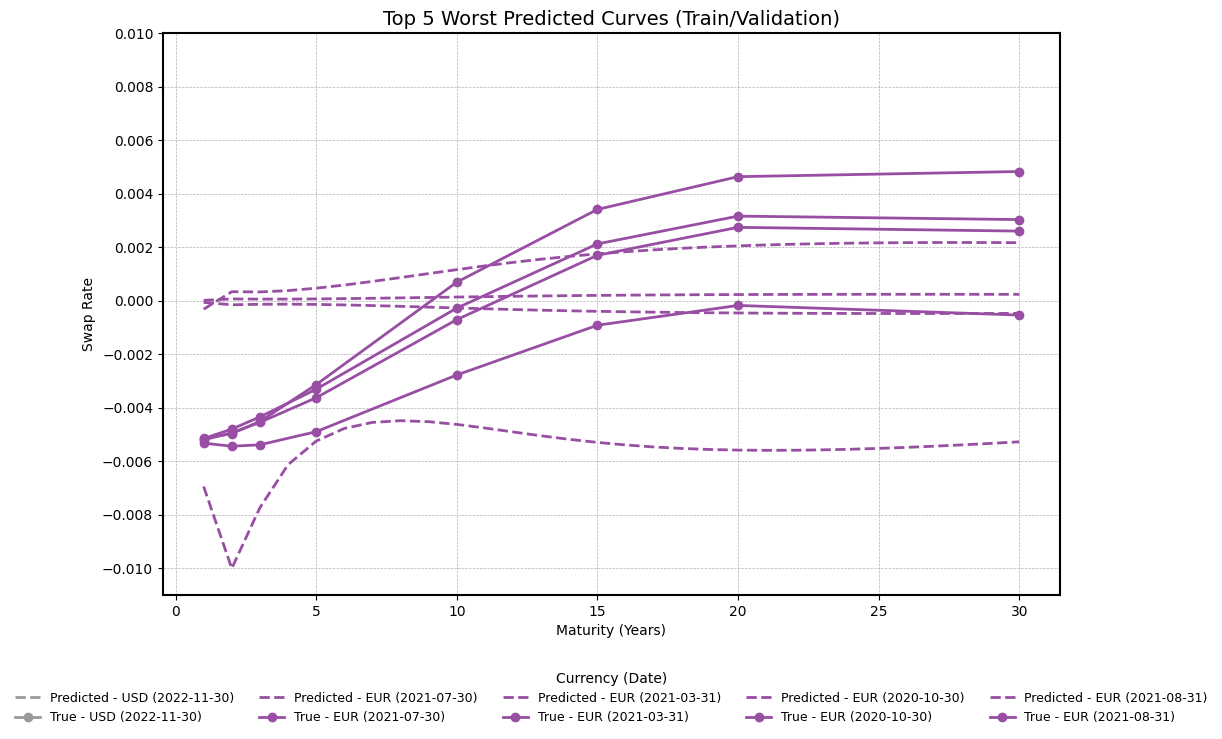

In [ ]:
marker_styles = ['o', 's', '^', 'D', 'v', 'P', '*', 'X', '<', '>']

selected_indices = [0, 1, 2, 4, 9, 14, 19, 29]
selected_maturities = [1, 2, 3, 5, 10, 15, 20, 30]
full_maturities = list(range(1, 31))

custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}
fallback_color = "#000000"

train_val_tensor = torch.cat((train_tensor, val_tensor), dim=0)
train_val_dates = np.concatenate((train_dates_np, val_dates_np))
train_val_currencies = np.concatenate((train_currencies_np, val_currencies_np))

model.eval()
G_out, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors, swap_rates_pred = model(train_val_tensor)
selected_pred = swap_rates_pred[:, selected_indices]
rmse_per_curve = torch.sqrt(torch.mean((selected_pred - train_val_tensor) ** 2, dim=1))

worst_indices = torch.topk(rmse_per_curve, 5).indices.cpu().numpy()

plt.figure(figsize=(12, 8))

for idx in worst_indices:
    currency = train_val_currencies[idx]
    date = pd.to_datetime(train_val_dates[idx]).strftime('%Y-%m-%d')
    color = custom_palette.get(currency, fallback_color)
    label = f"{currency} ({date})"

    true_curve = train_val_tensor[idx].numpy()
    pred_curve = swap_rates_pred[idx].cpu().detach().numpy()

    plt.plot(full_maturities, pred_curve, linestyle="--", linewidth=2, color=color, label=f"Predicted - {label}")
    plt.plot(selected_maturities, true_curve, marker='o', linewidth=2, color=color, label=f"True - {label}")
    #plt.text(
    #    x=selected_maturities[-1] + 0.4,
    #    y=true_curve[-1],
    #    s=label,
     #   fontsize=9,
    #    color=color,
    #    verticalalignment='center'
    #)


# --- Formatting ---
plt.title("Top 5 Worst Predicted Curves (Train/Validation)", fontsize=14)
plt.xlabel("Maturity (Years)")
plt.ylabel("Swap Rate")
plt.xticks(range(0, 31, 5))
plt.yticks(np.arange(-0.01, 0.061, 0.002))
plt.ylim(-0.011, 0.01)
plt.grid(True, linestyle="--", linewidth=0.5)

for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)

plt.legend(
    title="Currency (Date)",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.25),
    ncol=5,  
    frameon=False,
    fontsize=9,
    title_fontsize=10
)
plt.tight_layout()
plt.subplots_adjust(bottom=0.25) 
plt.show()

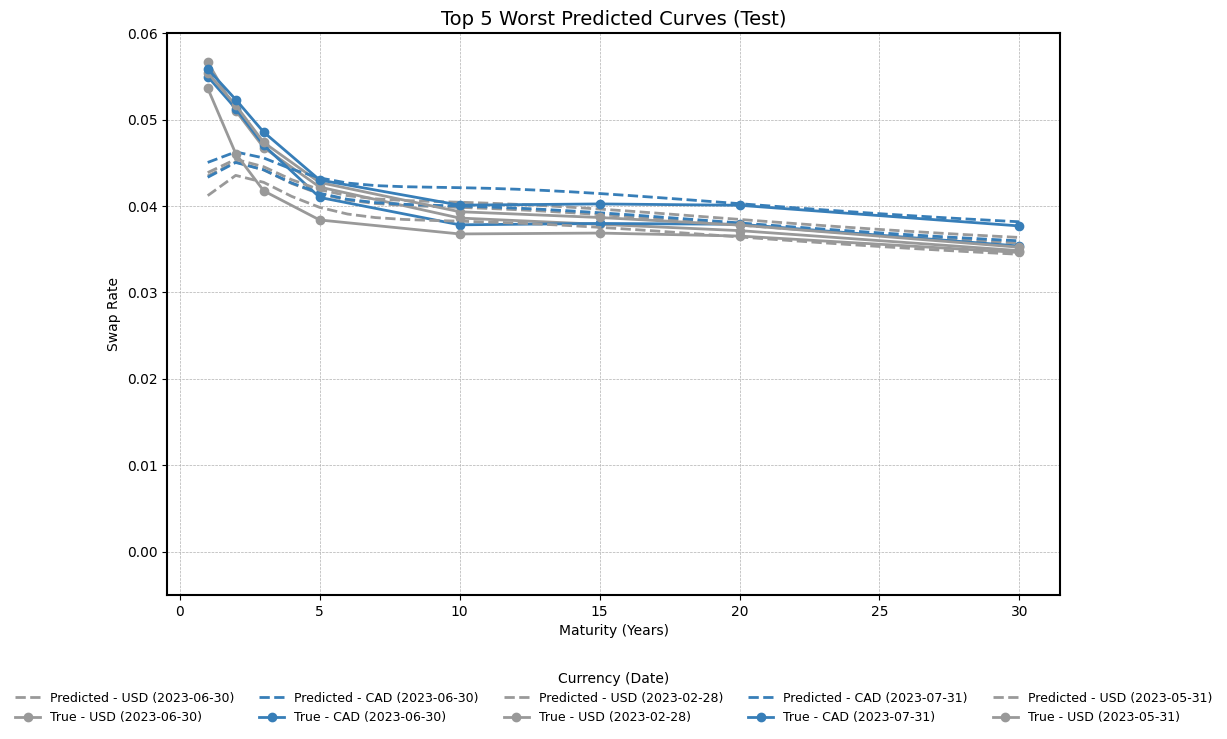

In [ ]:
data_full = pd.read_csv('data_2_full.csv', parse_dates=['Date'])
test_df = data_full[data_full['Date'].dt.year.isin([2023, 2024])].copy()
test_tensor = torch.tensor(test_df.iloc[:, 2:].values, dtype=torch.float32)
test_currencies = test_df["Currency"].values
test_dates = test_df["Date"].values

selected_indices = [0, 1, 2, 4, 9, 14, 19, 29]
selected_maturities = [1, 2, 3, 5, 10, 15, 20, 30]
full_maturities = list(range(1, 31))

custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}
fallback_color = "#000000"

model.eval()
G_out, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors, swap_rates_pred = model(test_tensor)
selected_pred = swap_rates_pred[:, selected_indices]
rmse_per_curve = torch.sqrt(torch.mean((selected_pred - test_tensor) ** 2, dim=1))

worst_indices = torch.topk(rmse_per_curve, 5).indices.cpu().numpy()

plt.figure(figsize=(12, 8))

for idx in worst_indices:
    currency = test_currencies[idx]
    date = pd.to_datetime(test_dates[idx]).strftime('%Y-%m-%d')
    color = custom_palette.get(currency, fallback_color)
    label = f"{currency} ({date})"

    true_curve = test_tensor[idx].numpy()
    pred_curve = swap_rates_pred[idx].cpu().detach().numpy()

    plt.plot(full_maturities, pred_curve, linestyle="--", linewidth=2, color=color, label=f"Predicted - {label}")
    plt.plot(selected_maturities, true_curve, marker='o', linewidth=2, color=color, label=f"True - {label}")

plt.title("Top 5 Worst Predicted Curves (Test)", fontsize=14)
plt.xlabel("Maturity (Years)")
plt.ylabel("Swap Rate")
plt.xticks(range(0, 31, 5))
plt.yticks(np.arange(-0.01, 0.061, 0.01))
plt.ylim(-0.005, 0.06)
plt.grid(True, linestyle="--", linewidth=0.5)

for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)

plt.legend(
    title="Currency (Date)",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.25),
    ncol=5,
    frameon=False,
    fontsize=9,
    title_fontsize=10
)

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)
plt.show()

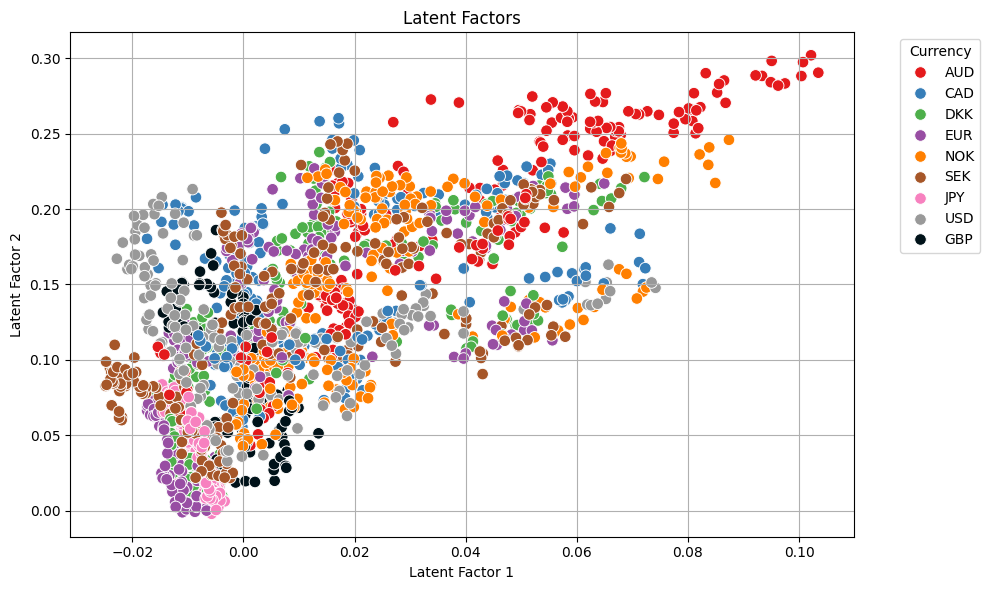

In [ ]:
data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']

train_df = data_full[data_full["Date"].dt.year <= 2018].copy()
val_df = data_full[(data_full["Date"].dt.year > 2018) & (data_full["Date"].dt.year < 2023)].copy()
test_df = data_full[data_full["Date"].dt.year >= 2023].copy()

train_df["Set"] = "Train"
val_df["Set"] = "Validation"
test_df["Set"] = "Test"
combined_df = pd.concat([train_df, val_df, test_df])

data_tensor = torch.tensor(combined_df[maturity_cols].values, dtype=torch.float32)
currencies = combined_df["Currency"].values
sets = combined_df["Set"].values

#model.load_state_dict(torch.load("best_fiae2_model_final.pt"))
model.eval()
G_out, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors, swap_rates_pred = model(data_tensor)

legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

latent_df = pd.DataFrame({
    "Latent_1": z[:, 0].detach().numpy(),
    "Latent_2": z[:, 1].detach().numpy(),
    "Currency": currencies,
    "Set": sets
})

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=latent_df,
    x="Latent_1", y="Latent_2",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette,
    s=70
)
plt.title("Latent Factors")
plt.xlabel("Latent Factor 1")
plt.ylabel("Latent Factor 2")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Currency")
plt.tight_layout()
plt.show()

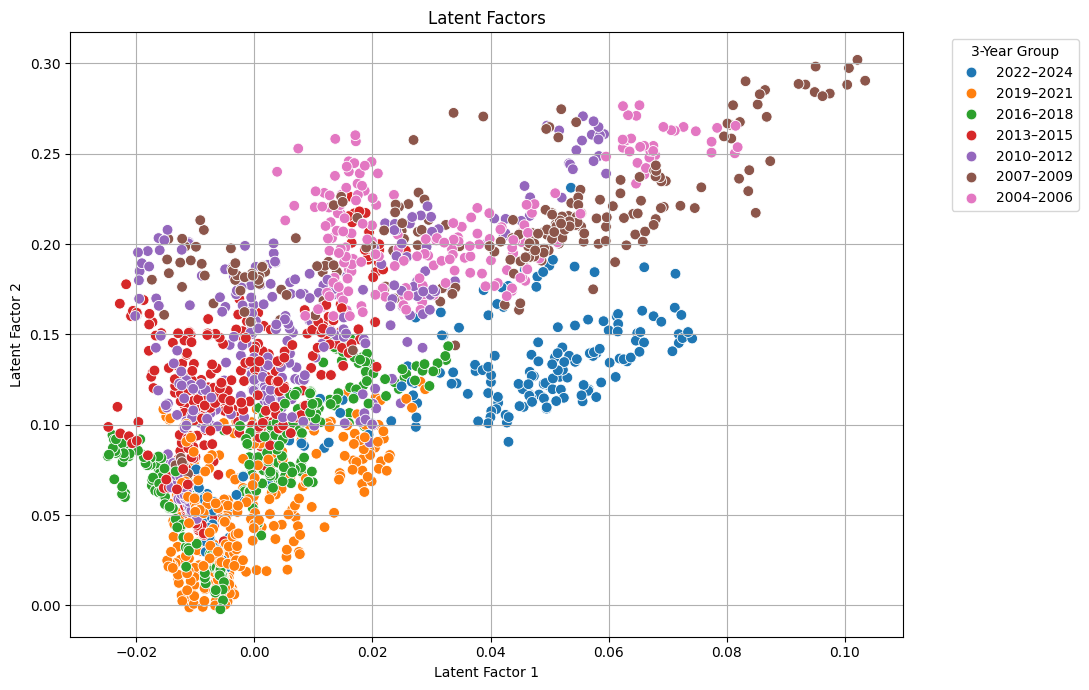

In [ ]:
data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year

data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

def label_year_group(year):
    base = (year - 2004) // 3 * 3 + 2004
    return f"{base}–{base+2}"

data_filtered["YearGroup"] = data_filtered["Year"].apply(label_year_group)

data_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
currencies = data_filtered["Currency"].values
year_groups = data_filtered["YearGroup"].values

model.eval()
G_out, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors, swap_rates_pred = model(data_tensor)

latent_df = pd.DataFrame({
    "Latent_1": z[:, 0].detach().numpy(),
    "Latent_2": z[:, 1].detach().numpy(),
    "Currency": currencies,
    "YearGroup": year_groups
})

plt.figure(figsize=(11, 7))
sns.scatterplot(
    data=latent_df, x="Latent_1", y="Latent_2",
    hue="YearGroup", palette="tab10", s=60
)
plt.title("Latent Factors")
plt.xlabel("Latent Factor 1")
plt.ylabel("Latent Factor 2")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="3-Year Group")
plt.tight_layout()
plt.show()

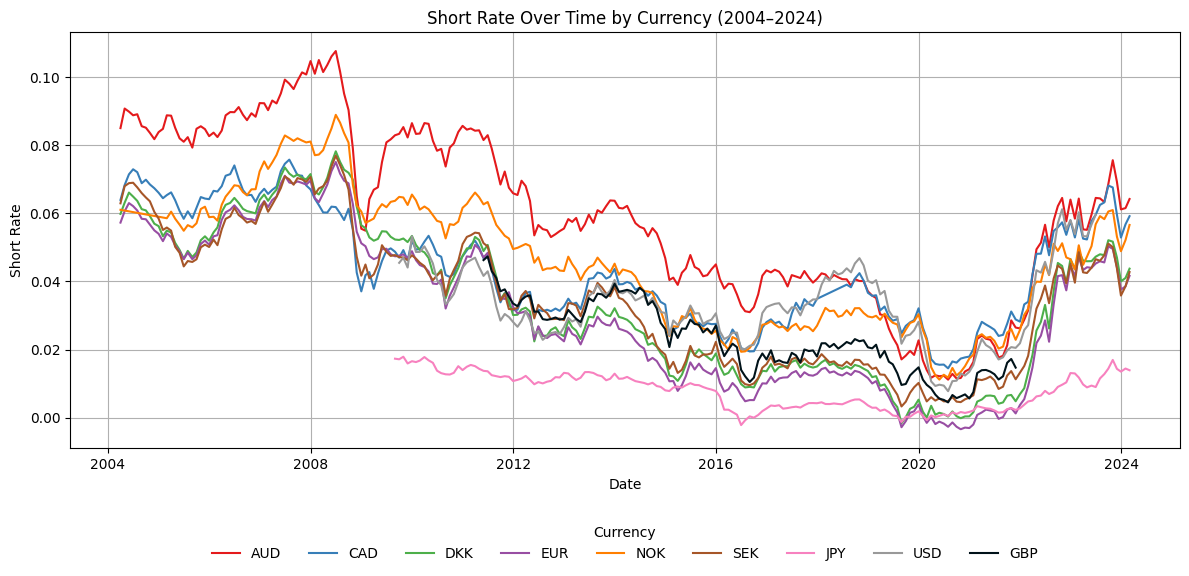

In [ ]:
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

model.eval()
G_out, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors, swap_rates_pred = model(x_tensor)
short_rates = risk_neutral_rate[:, 0].cpu().detach().numpy()

df_risk_neutral = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "RiskNeutralRate": short_rates
})

plt.close('all')
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_risk_neutral,
    x="Date",
    y="RiskNeutralRate",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette
)
plt.title("Short Rate Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel("Short Rate")
plt.grid(True)

plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.tight_layout()
plt.show()

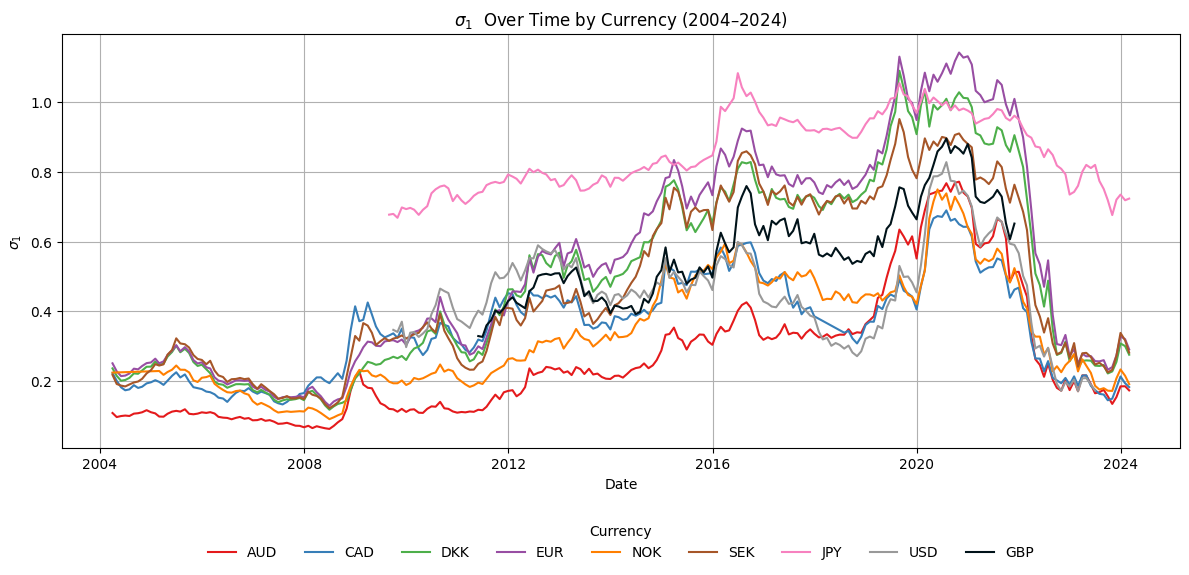

In [ ]:
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

model.eval()
G_out, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors, swap_rates_pred = model(x_tensor)
sigma1_at_short_maturity = sigma1[:, 0].detach().cpu().numpy()

df_risk_neutral = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "sigma_1": sigma1_at_short_maturity
})

plt.close('all')
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_risk_neutral,
    x="Date",
    y="sigma_1",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette
)
plt.title(r"$\sigma_1$  Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel(r"$\sigma_1$ ")
plt.grid(True)

plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.tight_layout()
plt.show()

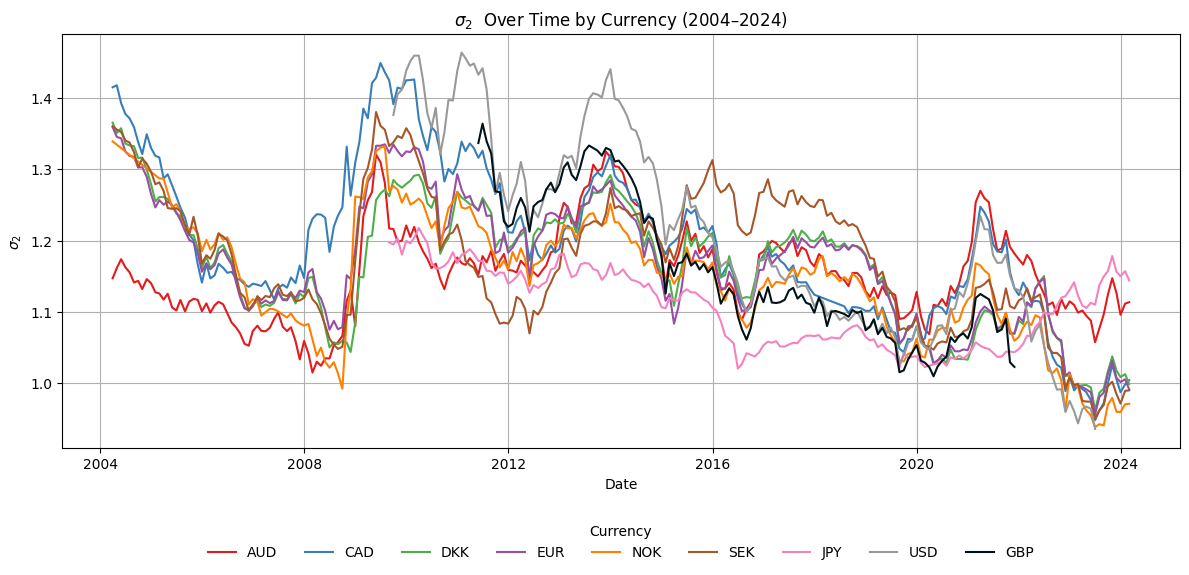

In [ ]:
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

model.eval()
G_out, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors, swap_rates_pred = model(x_tensor)
sigma2_at_short_maturity = sigma2[:, 0].detach().cpu().numpy()

df_risk_neutral = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "sigma_2": sigma2_at_short_maturity
})

plt.close('all')
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_risk_neutral,
    x="Date",
    y="sigma_2",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette
)
plt.title(r"$\sigma_2$  Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel(r"$\sigma_2$ ")
plt.grid(True)

plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.tight_layout()
plt.show()

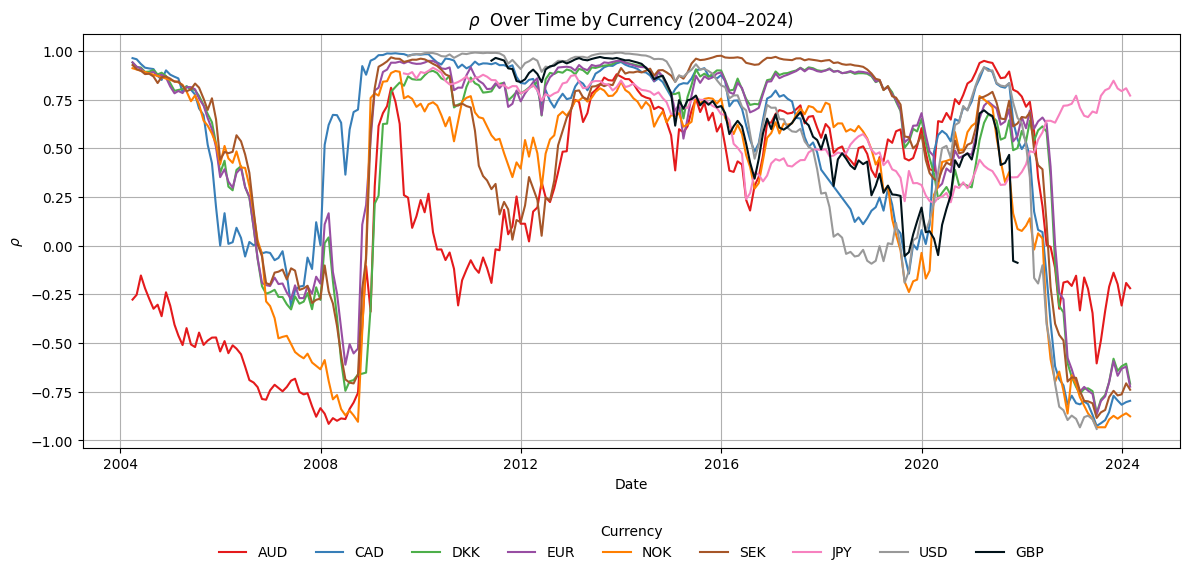

In [ ]:
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

model.eval()
G_out, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors, swap_rates_pred = model(x_tensor)
rho = rho1[:, 0].detach().cpu().numpy()

df_risk_neutral = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "rho": rho
})

plt.close('all')
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_risk_neutral,
    x="Date",
    y="rho",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette
)
plt.title(r"$\rho$  Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel(r"$\rho$ ")
plt.grid(True)

plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.tight_layout()
plt.show()

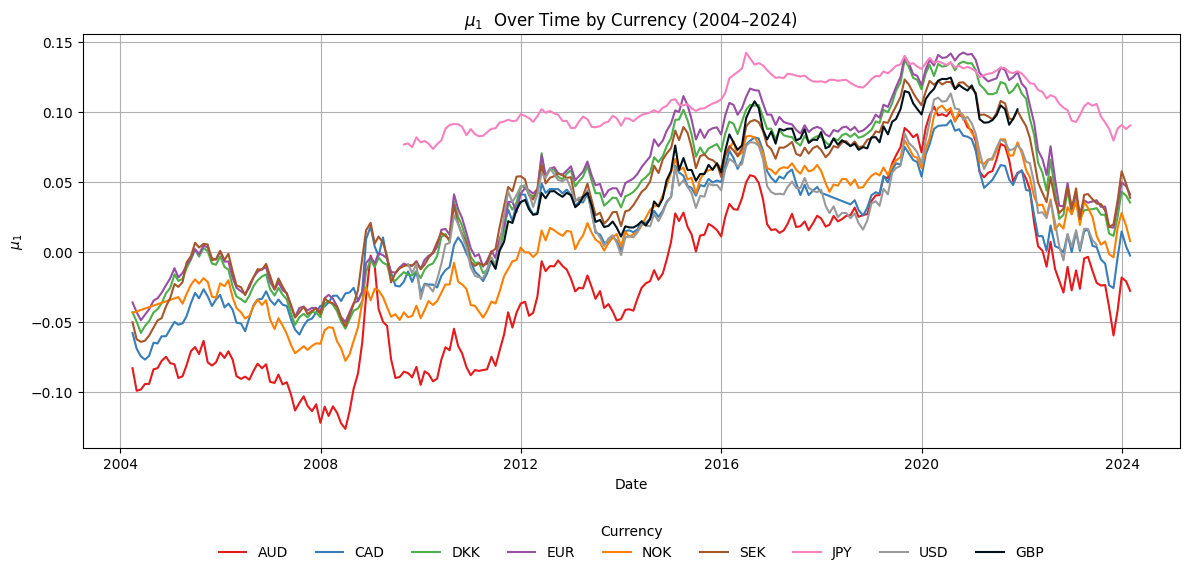

In [ ]:
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

model.eval()
G_out, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors, swap_rates_pred = model(x_tensor)
mu1 = mu[:, 0, 0].detach().cpu().numpy()

df_risk_neutral = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "sigma_1": mu1
})

plt.close('all')
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_risk_neutral,
    x="Date",
    y="sigma_1",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette
)
plt.title(r"$\mu_1$  Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel(r"$\mu_1$ ")
plt.grid(True)

plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.tight_layout()
plt.show()

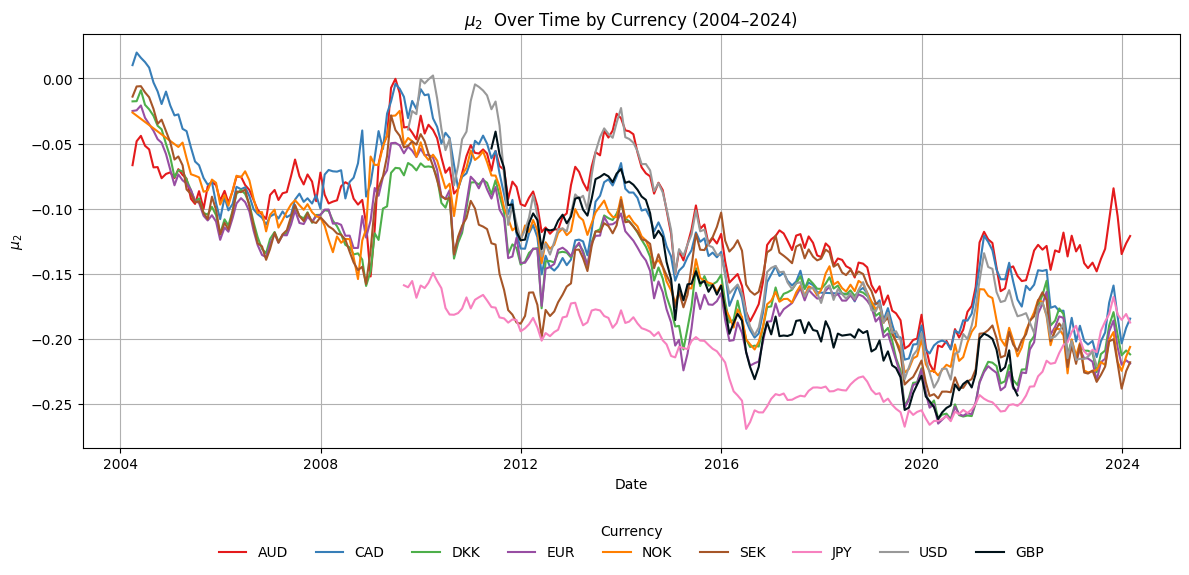

In [ ]:
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

model.eval()
G_out, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors, swap_rates_pred = model(x_tensor)
mu1 = mu[:, 0, 1].detach().cpu().numpy()

df_risk_neutral = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "sigma_1": mu1
})

plt.close('all')
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_risk_neutral,
    x="Date",
    y="sigma_1",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette
)
plt.title(r"$\mu_2$  Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel(r"$\mu_2$ ")
plt.grid(True)

plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.tight_layout()
plt.show()

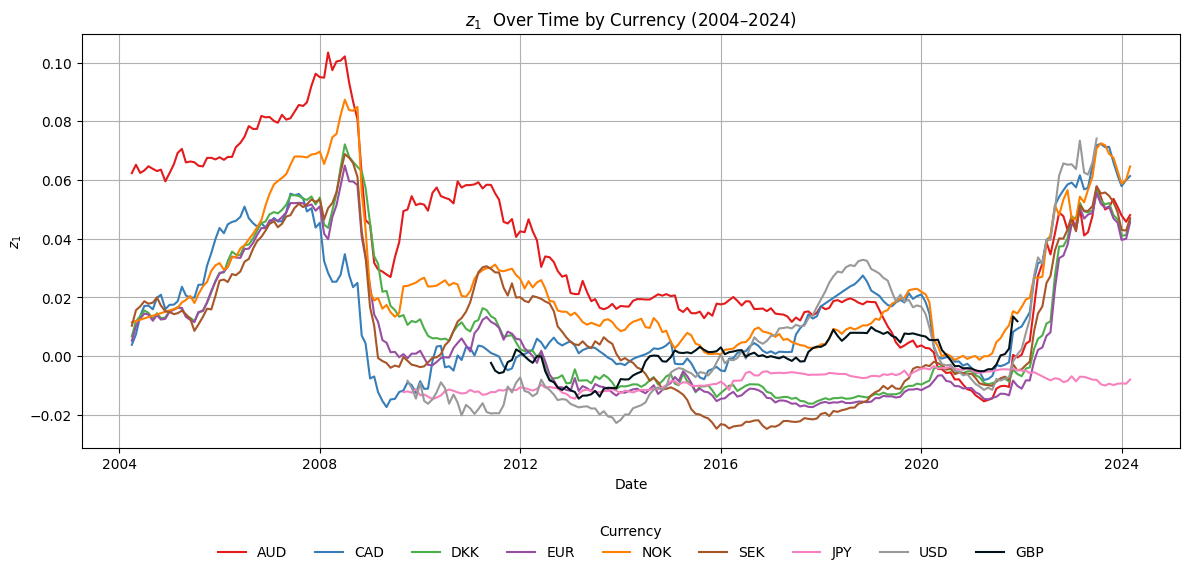

In [ ]:
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

model.eval()
G_out, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors, swap_rates_pred = model(x_tensor)
mu1 = z[:, 0].detach().cpu().numpy()

df_risk_neutral = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "sigma_1": mu1
})

plt.close('all')
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_risk_neutral,
    x="Date",
    y="sigma_1",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette
)
plt.title(r"$z_1$  Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel(r"$z_1$ ")
plt.grid(True)

plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.tight_layout()
plt.show()

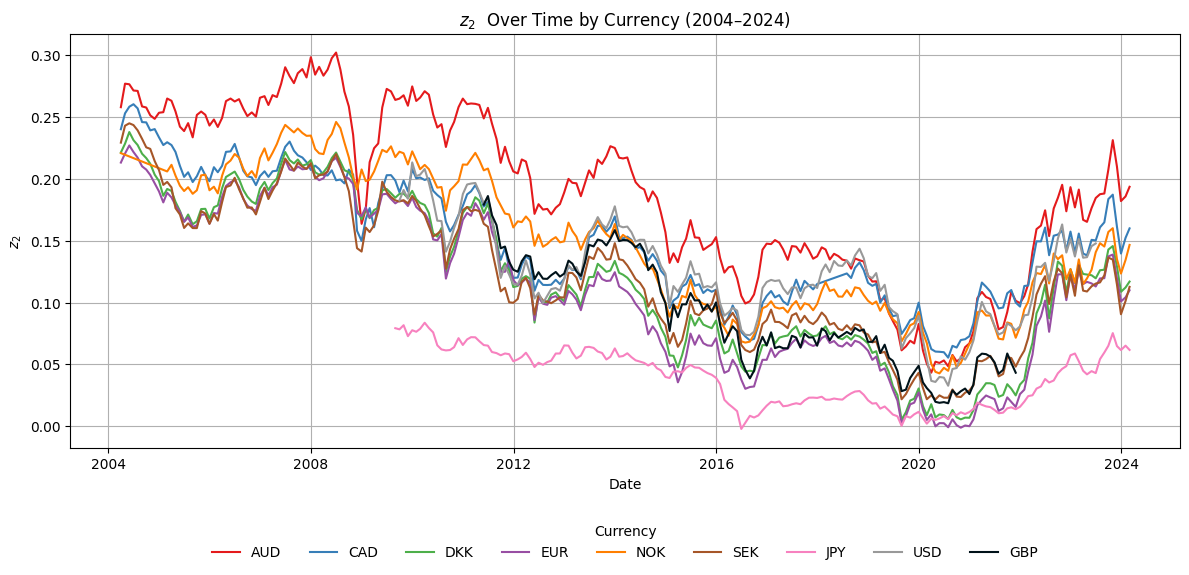

In [ ]:
legend_order = ['AUD', 'CAD', 'DKK', 'EUR', 'NOK', 'SEK', 'JPY', 'USD', "GBP"]
custom_palette = {
    'AUD': "#E41A1C", 'CAD': "#377EB8", 'DKK': "#4DAF4A", 'EUR': "#984EA3",
    'NOK': "#FF7F00", 'SEK': "#A65628", 'JPY': "#F781BF", 'USD': "#999999", "GBP": "#001219"
}

data_full = pd.read_csv("data_2_full.csv", parse_dates=["Date"])
maturity_cols = ['1Y', '2Y', '3Y', '5Y', '10Y', '15Y', '20Y', '30Y']
data_full["Year"] = data_full["Date"].dt.year
data_filtered = data_full[data_full["Year"].between(2004, 2024)].copy()

x_tensor = torch.tensor(data_filtered[maturity_cols].values, dtype=torch.float32)
dates = data_filtered["Date"].values
currencies = data_filtered["Currency"].values

model.eval()
G_out, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors, swap_rates_pred = model(x_tensor)
mu1 = z[:, 1].detach().cpu().numpy()

df_risk_neutral = pd.DataFrame({
    "Date": dates,
    "Currency": currencies,
    "sigma_1": mu1
})

plt.close('all')
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_risk_neutral,
    x="Date",
    y="sigma_1",
    hue="Currency",
    hue_order=legend_order,
    palette=custom_palette
)
plt.title(r"$z_2$  Over Time by Currency (2004–2024)")
plt.xlabel("Date")
plt.ylabel(r"$z_2$ ")
plt.grid(True)

plt.legend(
    title="Currency",
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    ncol=9,
    frameon=False
)

plt.tight_layout()
plt.show()

In [ ]:
model.eval()

G_out, risk_neutral_rate, gradients_maturities, hessian, sigma_matrix, mu, gradients_latent, maturities, z, sigma1, sigma2, rho1, discount_factors, predicted_swaps = model(train_tensor)

sigma_H_sigma = torch.matmul(sigma_matrix.transpose(-1, -2), torch.matmul(hessian, sigma_matrix))
trace_sigma_H_sigma = sigma_H_sigma[..., 0, 0] + sigma_H_sigma[..., 1, 1]
alpha = (- gradients_maturities + torch.sum(gradients_latent * mu, dim=2) + 0.5 * trace_sigma_H_sigma) / G_out
beta = risk_neutral_rate / G_out

sigma_grad_outer = torch.matmul(gradients_latent.unsqueeze(-1), gradients_latent.unsqueeze(-2))
gamma_matrix = torch.matmul(sigma_matrix.transpose(-1, -2), torch.matmul(sigma_grad_outer, sigma_matrix))
gamma = 0.5 * (gamma_matrix[..., 0, 0] + gamma_matrix[..., 1, 1])

zero_mask = (alpha.abs() < 1e-11)
B_z = beta * maturities
B_nz = (beta / alpha) * (torch.exp(alpha * maturities) - 1)
B = torch.where(zero_mask, B_z, B_nz)
A = gamma * (B ** 2) * maturities
gammaB2 = gamma * B ** 2

#torch.save({'alpha': alpha.cpu(), 'beta': beta.cpu(), 'gamma': gamma.cpu(),
#            'B': B.cpu(), 'A': A.cpu(), 'gammaB2': gammaB2.cpu()}, "train_ode_components.pt")

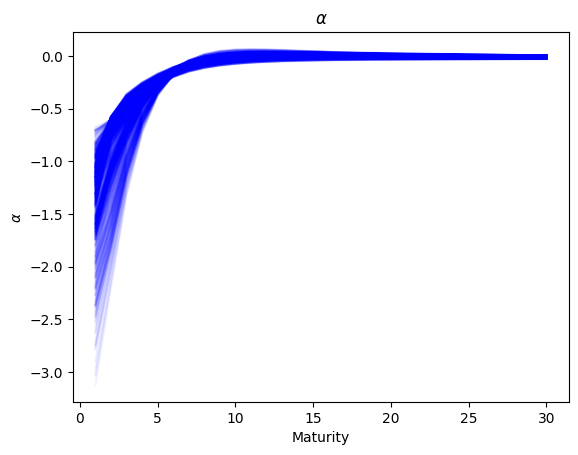

In [ ]:
#components = torch.load("train_ode_components.pt")
##alpha = components["alpha"]
#beta = components["beta"]
#gamma = components["gamma"]
#B = components["B"]
#A = components["A"]
#gammaB2 = components["gammaB2"]

for i in range(alpha.shape[0]):
    plt.plot(range(1, 31), alpha.detach()[i], alpha=0.05, color="blue")
plt.title(r"$\alpha$")
plt.xlabel("Maturity")
plt.ylabel(r"$\alpha$")
plt.show()

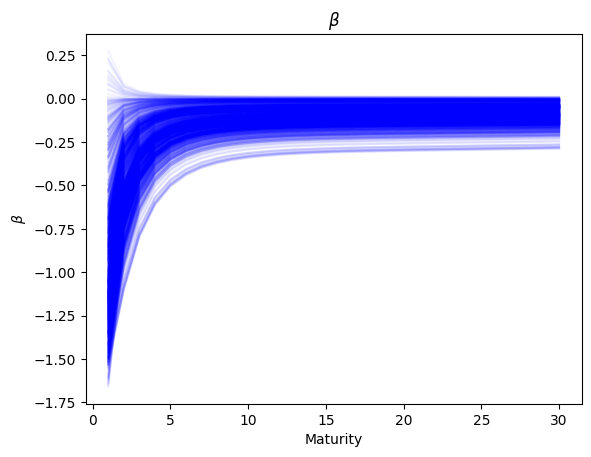

In [ ]:
for i in range(beta.shape[0]):
    plt.plot(range(1, 31), beta.detach()[i], alpha=0.05, color="blue")
plt.title(r"$\beta$")
plt.xlabel("Maturity")
plt.ylabel(r"$\beta$")
plt.show()

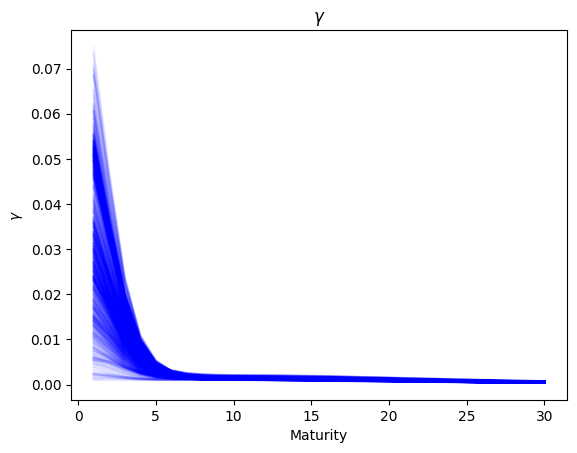

In [ ]:
for i in range(gamma.shape[0]):
    plt.plot(range(1, 31), gamma.detach()[i], alpha=0.05, color="blue")
plt.title(r"$\gamma$")
plt.xlabel("Maturity")
plt.ylabel(r"$\gamma$")
plt.show()

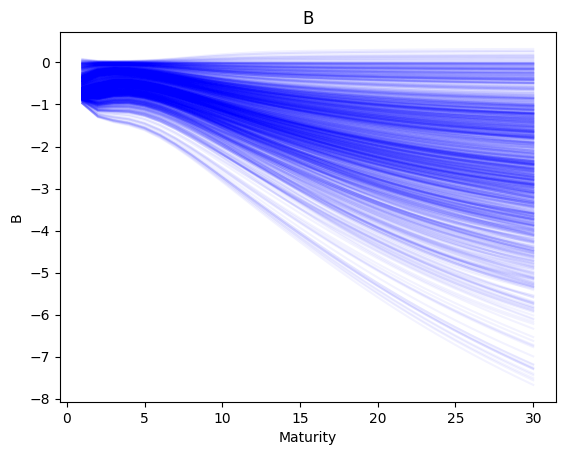

In [ ]:
for i in range(B.shape[0]):
    plt.plot(range(1, 31), B.detach()[i], alpha=0.05, color="blue")
plt.title("B")
plt.xlabel("Maturity")
plt.ylabel("B")
plt.show()

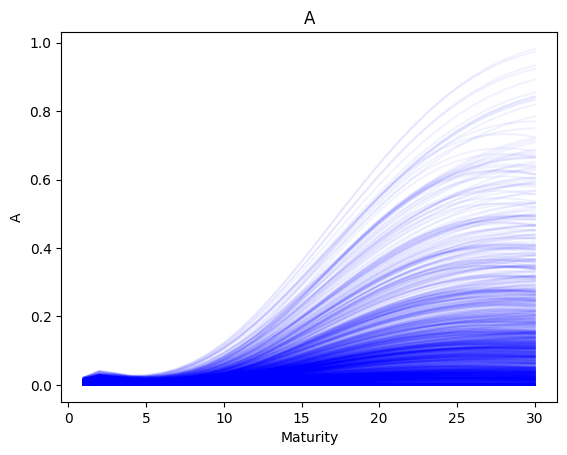

In [ ]:
for i in range(A.shape[0]):
    plt.plot(range(1, 31), A.detach()[i], alpha=0.05, color="blue")
plt.title("A")
plt.xlabel("Maturity")
plt.ylabel("A")
plt.show()

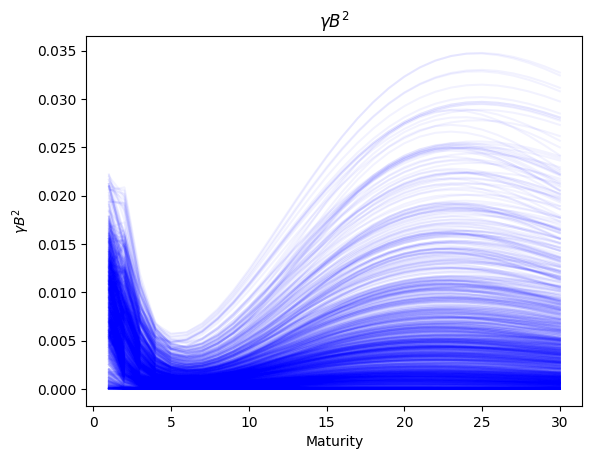

In [ ]:
for i in range(gammaB2.shape[0]):
    plt.plot(range(1, 31), gammaB2.detach()[i], alpha=0.05, color="blue")
plt.title(r"$\gamma B^2$")
plt.xlabel("Maturity")
plt.ylabel(r"$\gamma B^2$")
plt.show()